In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from numbers import Number

dir_path = os.getcwd()
file = dir_path + '/private_ads_clio.csv'
data = pd.read_csv(file)
#data = data.drop_duplicates()

data.head()

,make,model,price,year,kilometers,kilowatts,engine_type,created_at
0,renault,clio,100.0,2003,232350,55,petrol,2020-07-23
1,renault,clio,100.0,1999,170000,43,petrol,2020-07-17
2,renault,clio,100.0,1993,94000,43,petrol,2020-09-09
3,renault,clio,100.0,1999,195000,58,petrol,2020-05-13
4,renault,clio,100.0,2003,270000,60,diesel,2020-05-30


### Price distribution

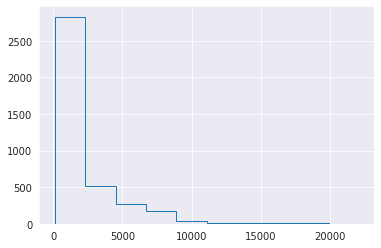

In [2]:
sns.set_style('darkgrid')
plt.hist(data['price'], histtype='step')
plt.show()

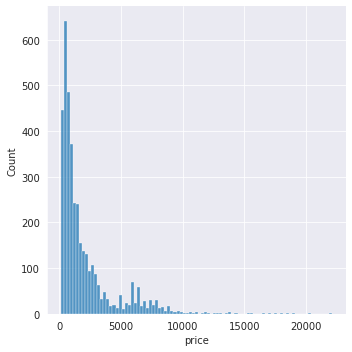

In [3]:
sns.displot(data.price)
plt.show()

We see that our data is skewed to the left, we have a lot more cheaper cars than expensive ones. 

### Mean, Median and Variance

In [4]:
print('Mean:',data.price.mean())
print('Median:',data.price.median())
print('Standard Deviation:',data.price.std())
print('Variance:',data.price.var())

Mean: 2033.7166882276842
Median: 1050.0
Standard Deviation: 2435.613187168418
Variance: 5932211.597508699


Mean and median are too far apart, this confirms what we concluded on previous graph. Variance is also high. 

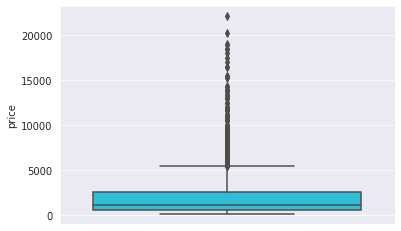

In [5]:
sns.boxplot(y=data.price,color='#13d2f2')
plt.show()

Dotted lines are outliers, majority of cars are well below 5k. 

### Diesel vs Petrol numbers

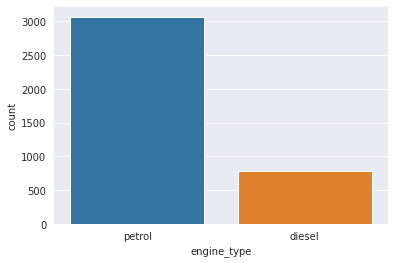

In [6]:
sns.countplot(x=data.engine_type)
plt.show()

Majority of renault clio cars are petrol in this dataset.

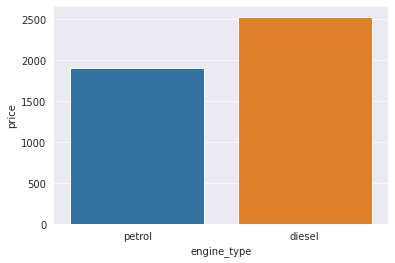

In [7]:
sns.barplot(x=data.engine_type,y=data.price,ci=None)
plt.show()

Diesel cars are more costly than petrol cars.

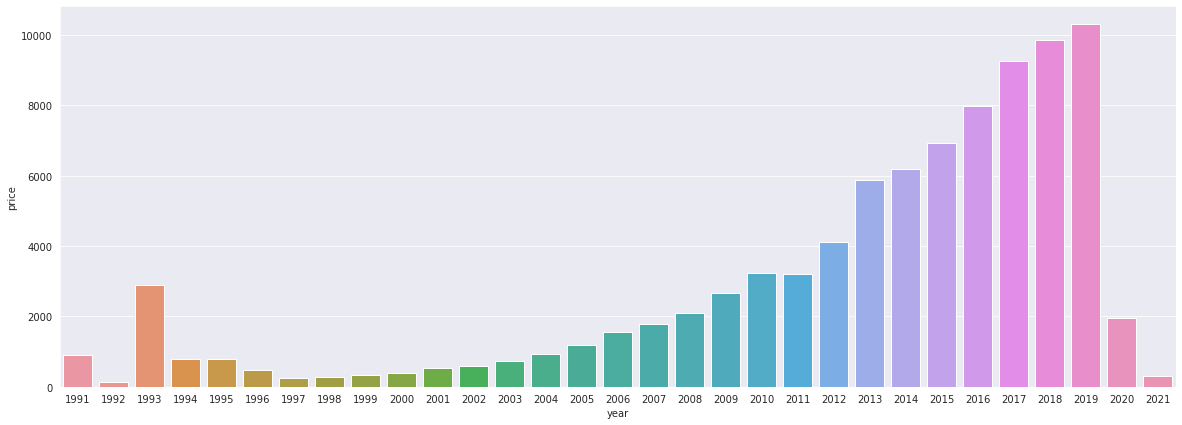

In [8]:
plt.figure(figsize=[20,7])
sns.barplot(x=data.year, y=data.price, ci=None)
plt.show()

We see that average price normally increases as you increase the model year. There are some outliers though, we have two instances of Clio Williams 2.0 1993 priced 16k, probably the same ad that was posted twice. So we need to clean this data further. In 2020 and 2021 we have some mislabeled Clio 2 models. 


### Remove outliers (clean data)


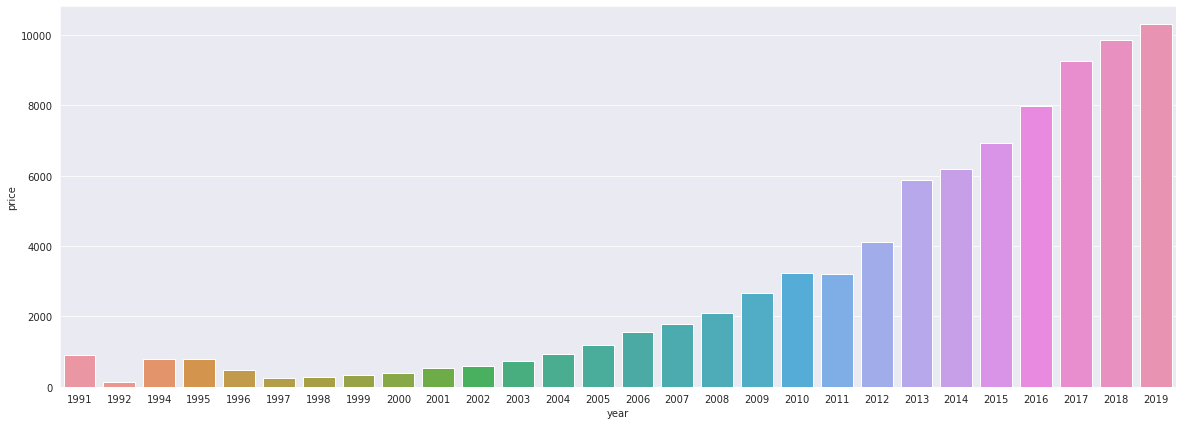

In [9]:
data = data[~data.year.isin([1993, 2020, 2021])]
plt.figure(figsize=[20,7])
sns.barplot(x=data.year, y=data.price, ci=None)
plt.show()

### Loking for correlations between price and other attributes

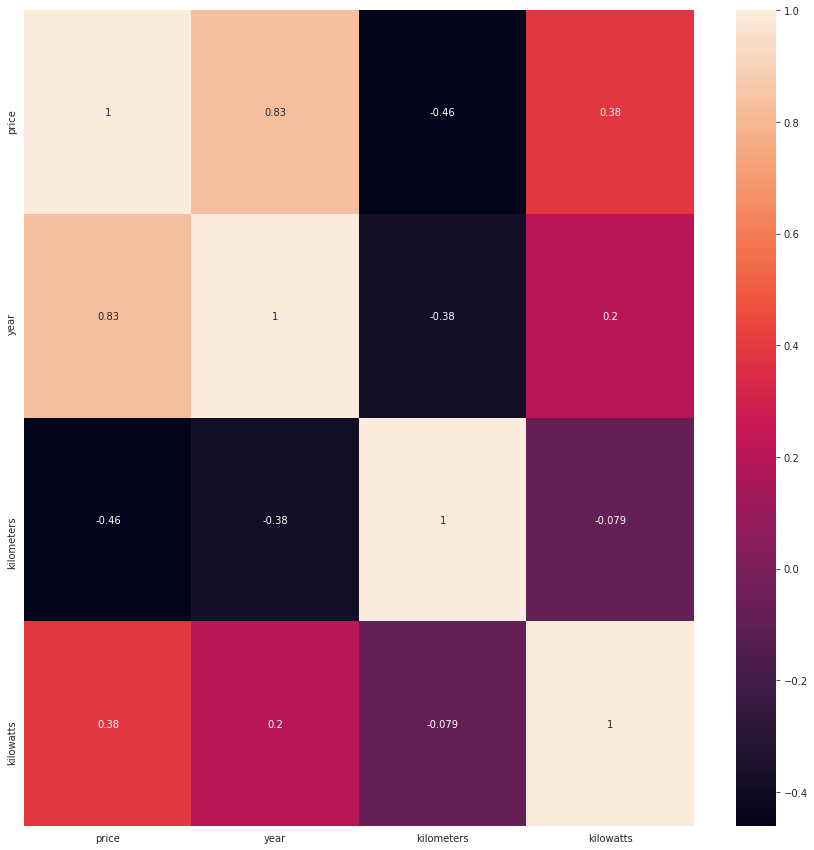

In [10]:
plt.figure(figsize=[15,15])
sns.heatmap(data.corr(),annot=True)
plt.show()

Price and year have strong positive corelation, while price and kilometers have  negative correlation, which is still not that strong.


### Find colinearity between predictors


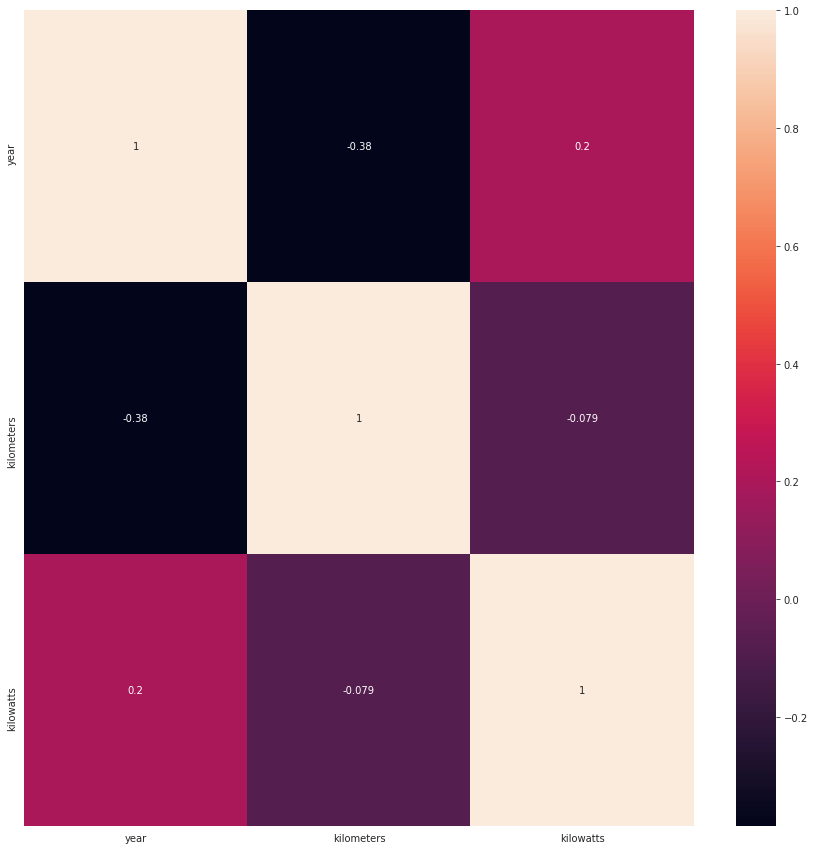

In [11]:

plt.figure(figsize=[15,15])
sns.heatmap(data.drop('price',axis=1).corr(),annot=True)
plt.show()

kilometers, years and kilowatts are not highly corelated, so we can use all three predictors

In [12]:
data=pd.get_dummies(data) # convert categorical value engine_type to numerical


### Linear regression


In [13]:
import statsmodels.api as sm

# testing only on 1 predictor - year
predictors=data['year']
target=data['price']
predictors= sm.add_constant(predictors)
lm_1 = sm.OLS(target,predictors).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     8540.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:22:18   Log-Likelihood:                -33168.
No. Observations:                3845   AIC:                         6.634e+04
Df Residuals:                    3843   BIC:                         6.635e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.152e+05   8843.116    -92.182      0.0

In [14]:
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

data = data.dropna(subset=['price', 'year', 'kilometers', 'kilowatts'], how='any') # drop any row that cointains NaN in any of subset columns
target = data['price']
predictors=data.drop('price',axis=1)
predictors2=predictors[['kilometers', 'year', 'kilowatts']]
predictors2= sm.add_constant(predictors2)
model2 = sm.OLS(target,predictors2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     4087.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:22:18   Log-Likelihood:                -32663.
No. Observations:                3845   AIC:                         6.533e+04
Df Residuals:                    3841   BIC:                         6.536e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.082e+05   8560.815    -82.721      0.0

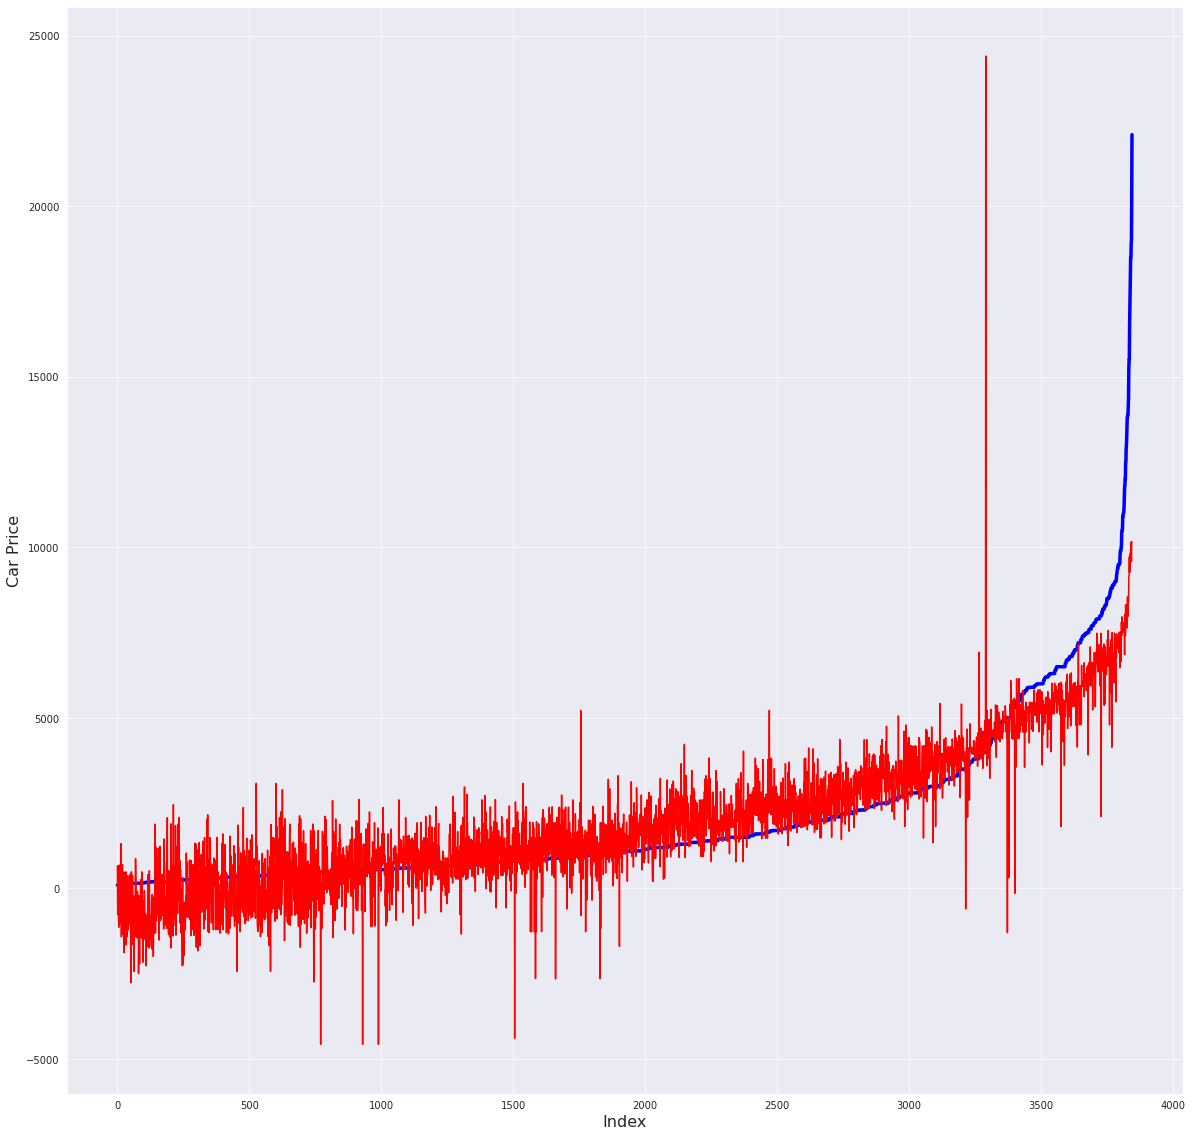

In [15]:
idxs = [i for i in range(1,len(target) + 1,1)]
pred = model2.predict(predictors2)
plt.figure(figsize=[20,20])
plt.plot(idxs, target, color="blue", linewidth=3.5, linestyle="-")     #Plotting Actual
plt.plot(idxs, pred, color="red",  linewidth=1.5, linestyle="-")       #Plotting predicted              
plt.xlabel('Index', fontsize=16)                               
plt.ylabel('Car Price', fontsize=16)
plt.show()



R^2 improved when we used kilometers, year and kilowatts as predictors, but our prediction model also generates negative predictions, which is the consequence of linear models being unbounded. We need to find a method that produces bounded outputs, i.e prices > 0. Linear regression is not the best fit here. It feels like this data set is not a great fit for linear regression.

### Polynomial regression

To avoid generating negative predictions, we first transform all numerical data to it's log and then generate model on transformed data. 

In [19]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def to_ln(x):
    return np.log1p(x)

polynomial_features= PolynomialFeatures(degree=3)

target = data['price'].apply(to_ln)
predictors=data.drop('price',axis=1)
predictors=predictors[['kilometers', 'year', 'kilowatts']]
predictors[['kilometers', 'year', 'kilowatts']] = predictors[['kilometers', 'year', 'kilowatts']].apply(to_ln)

xp = polynomial_features.fit_transform(predictors)
#predictors = sm.add_constant(predictors)
poly_model = sm.OLS(target,xp).fit()
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1322.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:26:34   Log-Likelihood:                -1781.9
No. Observations:                3845   AIC:                             3604.
Df Residuals:                    3825   BIC:                             3729.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.987e+09    1.3e+08     15.329      0.000    1.73e+09    2.24e+09
x1          -1.07e+05    3.4e+04     -3.146      0.002   -1.74e+05   -4.03e+04
x2         -7.841e+08   5.12e+07    -15.327      0.000   -8.84e+08   -6.84e+08
x3          7.761e+05    3.2e+05      2.424      0.015    1.48e+05     1.4e+06
x4           -22.2071      6.552     -3.389      0.001     -35.053      -9.361
x5          2.836e+04   8950.205      3.168      0.002    1.08e+04    4.59e+04
x6          -316.4312     83.965     -3.769      0.000    -481.051    -151.811
x7          1.031e+08   6.73e+06     15.325      0.000    8.99e+07    1.16e+08
x8         -2.047e+05   8.44e+04     -2.426      0.015    -3.7e+05   -3.93e+04
x9          1025.0614    269.564      3.803      0.000     496.559    1553.564
x10           -0.0070      0.001    -12.466      0.000      -0.008      -0.006
x11            2.9529      0.865      3.414      0.001       1.257       4.649
x12           -0.0266      0.013     -2.022      0.043      -0.052      -0.001
x13        -1879.2864    589.069     -3.190      0.001   -3034.206    -724.367
x14           41.7547     11.063      3.774      0.000      20.065      63.444
x15           -0.0833      0.054     -1.534      0.125      -0.190       0.023
x16        -4.523e+06   2.95e+05    -15.323      0.000    -5.1e+06   -3.94e+06
x17         1.349e+04   5556.706      2.429      0.015    2600.106    2.44e+04
x18         -134.3174     35.464     -3.787      0.000    -203.848     -64.787
x19           -0.1781      0.033     -5.316      0.000      -0.244      -0.112
==============================================================================
Omnibus:                      351.592   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1002.026
Skew:                          -0.494   Prob(JB):                    2.59e-218
Kurtosis:                       5.298   Cond. No.                     5.11e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.64e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

When plotting predicted vs actual data points, we first undo the log function to get back normal values. We see that all predictions now are positive, but still the solution is not very good. This problem should be solved with other methods. 

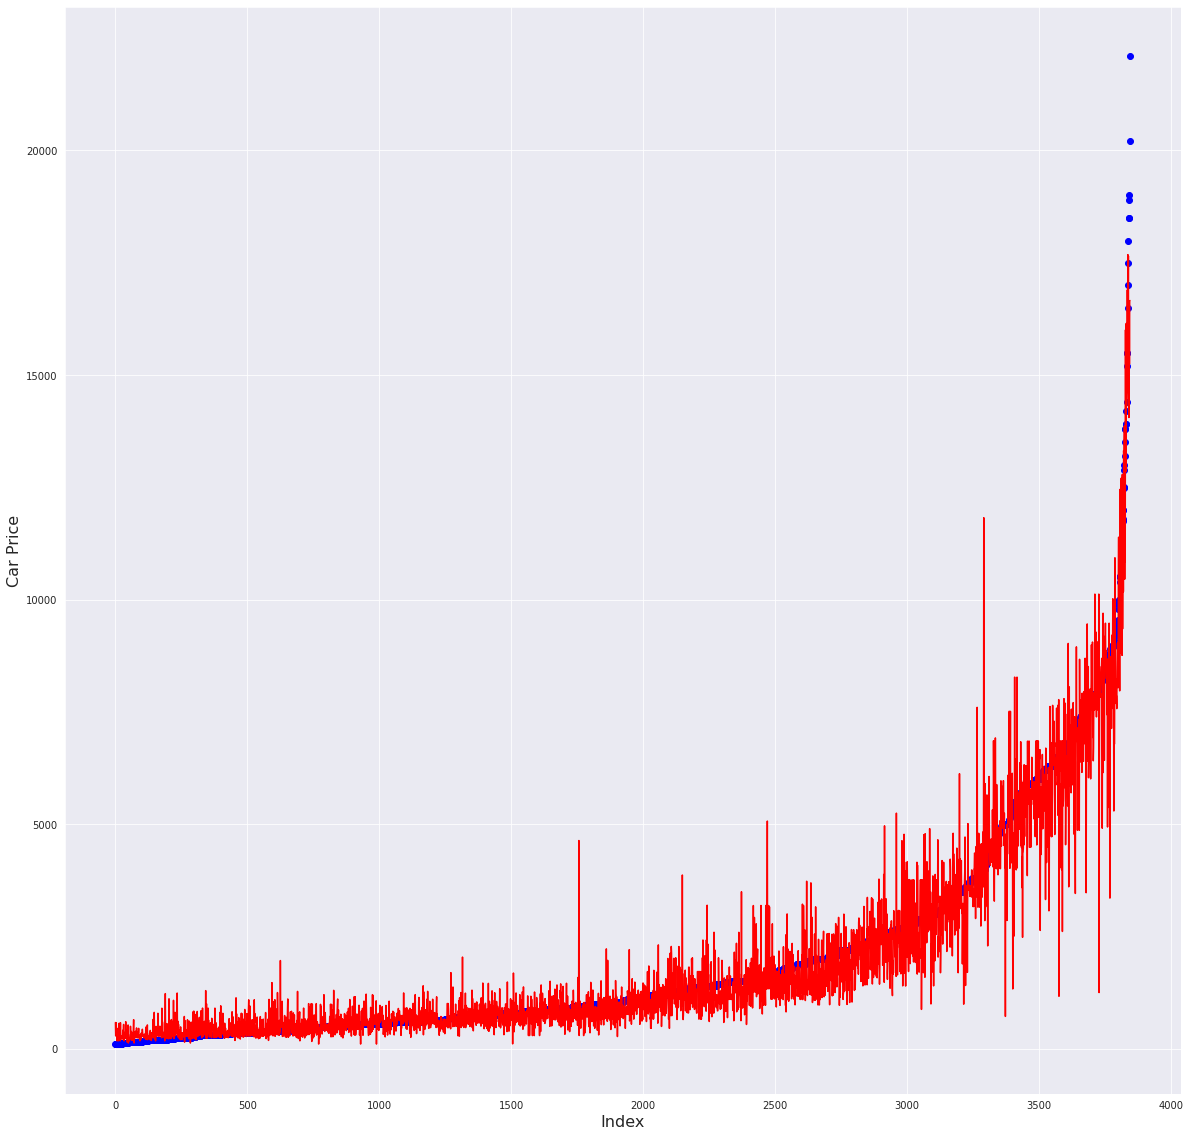

In [18]:
def inverse_ln(x):
    return np.expm1(x)
    
target_inverse = target.apply(inverse_ln)
idxs = [i for i in range(1,len(target_inverse) + 1,1)]
pred = poly_model.predict(xp)
pred_inverse = inverse_ln(pred)
plt.figure(figsize=[20,20])
plt.scatter(idxs, target_inverse, color="blue")     #Plotting Actual
plt.plot(idxs, pred_inverse, color="red")       #Plotting predicted              
plt.xlabel('Index', fontsize=16)                               
plt.ylabel('Car Price', fontsize=16)
plt.show()